# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance. Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [2]:
eps = 1e-5
dataPath = "./data/"
baseUrl = "https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project";
DEBUG = True


## Import libraries

In [4]:
import numpy as np
import pandas as pd
import math
import mip
import json
import networkx as nx
import matplotlib.pyplot as plt
import time
import csv

## Download instance

In [3]:
def downloadInstances(inst_ids):
    !rm -rf {dataPath}
    for inst_id in inst_ids:
        istanceUrl = f'{baseUrl}/instances/instance_{inst_id}.json';
        resultUrl = f'{baseUrl}/results/instance_{inst_id}.txt';
        !wget -q {istanceUrl} -P {dataPath}
        !wget -q {resultUrl} -P {dataPath}

## Logger

In [5]:
def log(s):
    if DEBUG:
        print(s)

### Compute distance

In [6]:
def fast_distance_matrix(x):
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

## Load instances

In [7]:
# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(f'./data/{filename}', 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(f'./data/{filename}', 'r') as f:
      result = f.read()
  return float(result)

def load_data(instance_id):
  instance_data = load_instance(f'instance_{instance_id}.json')
  expected_result = load_result(f'instance_{instance_id}.txt') if instance_id <= 4 else None
  return (instance_data, expected_result)
  

## Print result

In [9]:
def printVariableMatrix(var, label):
  log(f"\n{label}")
  for i in range(len(var)):
    log([f"{var[i][j].x:.5f}" for j in range(len(var[i]))])


def printVariableArray(var, label):
    log(f"\n{label}")
    log([f"{var[i].x:.5f}" for i in range(len(var))])


def printVarMatrixValue(var, i, j):
  log(f"{var[i][j].x:.5f}")


def printVariables(model, x = True, y = True, z = True):
  if x:
    printVariableArray(model.x, "X")
  if y:
    printVariableMatrix(model.y, "Y")
  if z:
    printVariableMatrix(model.y, "Z")
  

In [10]:
def compute_gap(obj_value, expected_result, relaxed_obj_value):
    result  = expected_result if expected_result != None else relaxed_obj_value
    gap = 100 * (obj_value - result) / result
    return (gap, expected_result == None)


def print_model_gap(model:Model, expected_result, relaxed_obj_value):
    log(f"Status: {model.m.status}")

    obj_value = model.m.objective_value;
    (gap, isApproximate) = compute_gap(obj_value, expected_result, relaxed_obj_value)

    if isApproximate:
        log(f"Obj Value = {obj_value:.5f}, Expected Result = {relaxed_obj_value:.5f} Gap ~ {gap:.5f} %")
    else:
        log(f"Obj Value = {obj_value:.5f}, Expected Result = {expected_result:.5f} Gap = {gap:.5f} %")

def print_model(model:Model, expected_result, relaxed_obj_value, figsize=(14, 14), font_size=8, textual = False, weight = False):
    m = model.m
    x = model.x
    y = model.y
    z = model.z
    I = model.I
    c = model.c
    
    print_model_gap(model, expected_result, relaxed_obj_value)

    if (textual):
        log("\n-----Farms-----")
        for i in I:
            if x[i].x > eps:
                log(f"[--- x_{i} = {x[i].x:.3f} ---]")
                for j in I:
                    if y[i][j].x > eps:
                        gain = model.Q * model.b * model.z[i][j].x - model.y[i][j].x * model.distances[i][j];
                        log(f"{j} -(y = {y[i][j].x:.5f} z = {z[i][j].x:.5f} gain = {gain:.5f})-> {i};")

    #Visualize solution on graph
    pos_c = {i: (model.points[i][0], model.points[i][1]) for i in I}
    nodepos = {**pos_c}
    
    g = nx.DiGraph(directed = True)
    g.add_nodes_from([i for i in I])

    if (weight):
        w_edges = [(j, i, f'y = {model.y[i][j].x:.5f}') for j in I for i in I if y[i][j].x > eps] 
        g.add_weighted_edges_from(w_edges)
    else:
        edges = [(j, i) for j in I for i in I if y[i][j].x > eps] 
        g.add_edges_from(edges)

    color = ['yellow' if  abs(model.x[i].x - 1) <= eps else ('cyan' if model.x[i].x < eps else 'orange') for i in I]
    plt.figure(1, figsize=figsize)
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx(g, font_size=font_size, pos=nodepos, node_color=color)
    nx.draw_networkx_edge_labels(g,pos=nodepos,edge_labels=labels)
    plt.show()    

## Model

Definition of the class for the Model.

When we initialize a new model we add all the parameters needed from the instance data, the different variables and the constraints for the linear solution. 

# Variables:

  * $x_i$: binary variable that is 1 if a plant is located at farm $i$ and 0 otherwise.
  * $y_{i,j}$: binary variable that is 1 if farm $j$ supplies corn chopping to farm $i$ and 0 otherwise.
  * $z_{i,j}$: variable that represent the number of tons of corn choppings that farm $j$ supplies to farm $i$.

# Constraints:

  * $p$ plants must be built

    $\sum_{i=1}^n x_i = p$

  * Each farm can supply corn choppings to at most one plant
  
  $$\sum_{i=1}^n y_{i,j} \leq 1 \quad \forall j$$
  
  $$\sum_{j=1}^n y_{i,j} \leq x_i * n \quad \forall i$$

  * The percentage of dry matter of the corn chopping burned at each plant must be within the required range

  $$k_{min} \leq \frac{\sum_{j=1}^n z_{i,j} \cdot a_j}{\sum_{j=1}^n z_{i,j}} \leq k_{max} \quad \forall i$$

  * The amount of energy produced at each plant must be lower than the maximum allowed

  $$\sum_{j=1}^n z_{i,j} \cdot Q \leq M \quad \forall i$$

# Objective function

We want to maximize the profit of the energy produced by the plants over the cost of acquiring the corn choppings from the farms.
$$\text{maximize} \sum_{i=1}^n \sum_{j=1}^n (Q \cdot b \cdot z_{i,j} - y_{i,j} \cdot d_{i,j})$$



In [8]:
class Model:
    def __init__(self, instance):
        self.M = instance["M"]
        self.Q = instance["Q"]
        self.a = np.array(instance["a"])
        self.b = instance["b"]
        self.c = instance["c"]
        self.kmax = instance["kmax"]
        self.kmin = instance["kmin"]
        self.n = instance['n']
        self.I = range(self.n)
        self.p = instance["p"]
        self.points = instance["points"]
        self.distances = fast_distance_matrix(np.array(self.points))

        self.m = mip.Model();
        self.setupVariables()
        self.setupConstraint()
                
        self.m.objective = mip.maximize(mip.xsum([self.z[i][j] * self.Q * self.b - self.y[i][j] * self.distances[i][j] for j in self.I for i in self.I]))
    
    def setupVariables(self):
        self.x = [self.m.add_var(var_type = mip.BINARY) for i in self.I]
        self.y = [[self.m.add_var(var_type = mip.BINARY) for j in self.I] for i in self.I]
        self.z = [[self.m.add_var(lb = 0) for j in self.I] for i in self.I]

    

    def isOptimal(self):
        return self.m.status == mip.OptimizationStatus.OPTIMAL

    def isModelInteger(self):
        for i in self.I:
            if (self.x[i].x > eps and self.x[i].x < 1 - eps):
                return False;
            for j in self.I:
                if (self.y[i][j].x > eps and self.y[i][j].x < 1 - eps):
                    return False;
        return True
        

    def setupConstraint(self):
        #build p plants
        self.m.add_constr(mip.xsum([self.x[i] for i in self.I]) == self.p)
        
        #each farm can be assigned to at most one farm
        for j in self.I:
            self.m.add_constr(mip.xsum([self.y[i][j] for i in self.I]) <= 1)


        for i in self.I:
            self.m.add_constr(mip.xsum([self.y[i][j] for j in self.I]) <= self.x[i] * self.n)

        #each farm can at most give c_i corn choppings, linking constraint
        for i in self.I:
            for j in self.I:
                self.m.add_constr(self.z[i][j] <= self.c[j] * self.y[i][j])

        # dry mattern percentage
        for i in self.I:
            chorn_choppings_aquired = mip.xsum([self.z[i][j] for j in self.I])
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) <= self.kmax * chorn_choppings_aquired)
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) >= self.kmin * chorn_choppings_aquired)

        
        # state regulations
        for i in self.I:
            self.m.add_constr(mip.xsum([self.z[i][j] for j in self.I]) * self.Q <= self.M)

## Final Algorithm

To solve this problem in a reasonable amount of time in all the different instances we decided to relax the integrality constraints on the variables $x$ and $y$ and to use a greedy cutting plane algorithm.

To find an integer solution, the algorithm goes through a series of iterations. In each iteration, it follows these steps:
  * First it optimizes the model.
  * Then it takes all the pairs plant-farm ($i$,$j$) with non integer values of $y_{ij}$ or $x_i$ and ranks them taking in consideration their distance, the amount of corn choppings that can be sent to one another (accounting for both capacity of the plant and the dry matter percentage) and the centrality of the plant w.r.t. the farms not yet assigned.
  * Finally it takes the best ($i$,$j$) pair and adds the constraint $$y_{ij} + x_{i} == 2$$ this way setting both values to 1.

This algorithm manages to reach a good solution (gap <1% in the instances 2 to 5) in a very small amount of time.


In [35]:
def computeMaxDryMatter(model: Model, sum_z, sum_z_w, j):
    if (sum_z > eps):
        max_z = max(0, (model.kmax * sum_z - sum_z_w) / (model.a[j] - model.kmax))
        return max_z

    if (model.a[j] <= model.kmax and model.a[j] >= model.kmin):
        return model.c[j]
    
    return 0

def isBetweenZeroAndOne(num):
    return num > eps and num < 1 - eps;

def computeStats(model:Model):
    real_obj_value = 0
    availability = [True for i in model.I]
    capacities = [model.M / model.Q for i in model.I]
    degrees = [0 for i in model.I]
    dry_matters = [(0, 0) for i in model.I]

    x_filled = 0
    for i in [k for k in model.I if model.x[k].x > eps]:
        if (model.x[i].x > 1 - eps):
            x_filled += 1
        for j in [k for k in model.I if model.y[i][k].x > 1 - eps]:
            if (model.x[i].x > 1 - eps):
                availability[j] = False
            capacities[i] -= model.z[i][j].x
            (sum_z, sum_z_w) = dry_matters[i]
            sum_z += model.z[i][j].x
            sum_z_w += model.z[i][j].x * model.a[j]
            dry_matters[i] = (sum_z, sum_z_w)
            degrees[i] += 1


    return availability, capacities, degrees, dry_matters, x_filled


def compute_centrality(model:Model, availability, i):
    centrality = 0
    neighbours = [k for k in model.I if availability[k] and k != i]
    for neighbour in neighbours:
        centrality += 100 * model.a[neighbour] - model.distances[i][neighbour]
    return centrality

def find_best_pair(model:Model):
    availability, capacities, degrees, dry_matters, x_filled = computeStats(model)
    
    max_pair = None
    max_rank = -math.inf

    for i in model.I:
        (sum_z, sum_z_w) = dry_matters[i]
        max_z_capacity = capacities[i]
        centraility = compute_centrality(model, availability, i)
        #set with the j such that the pairs (i, j) have some integrality problems
        S = [k for k in model.I if (isBetweenZeroAndOne(model.y[i][k].x) or (isBetweenZeroAndOne(model.x[i].x) and model.y[i][k].x > 1 - eps))]
        for j in S:
            max_z_dry_matter = computeMaxDryMatter(model, sum_z, sum_z_w, j)
            max_z = max(0, min(max_z_capacity, model.c[j]))
            #makes sense to limit z only if the degree of i is greater than one
            if (degrees[i] >= 1):
                max_z = min(max_z, max_z_dry_matter)
                
            rank = (max_z * model.Q * model.b  - model.distances[i][j]) + centraility
            #log(f'[{i,j}]: [max_z: {max_z}], [rank {rank}], [model.distances[i][j] {model.distances[i][j]}], centrality: {centraility}], ')
            if (rank > max_rank):
                max_rank = rank
                max_pair = (i, j)
        
    return max_pair


In [40]:
def solve(data):
    start_time = time.time()
    (inst, expected_result) = data;
    model = Model(inst)
    model.m.verbose = 0;
    model.m.optimize(relax=True)
    relaxed_obj_value = model.m.objective_value
    print_model(model, expected_result, relaxed_obj_value, weight=True)
    newConstraints = True;
    iteration = 0;
    
    while newConstraints and model.isOptimal():
        log('----------------------------------------------------------------------------------------------------')
        log(f'[Iteration: {iteration}]')
        iteration += 1
        newConstraints = False
        start_computing = time.time()
        pair = find_best_pair(model)

        if (pair != None):
            log(f'Pair: {pair}')
            i, j = pair
            relaxed_val = 2
            model.m.add_constr(model.y[i][j] + model.x[i] == relaxed_val);
            log(f'Relaxed y[{i}][{j}] + x[{i}] = {relaxed_val}')
            newConstraints = True;
        

        start_optimization = time.time()
        if (newConstraints):
            model.m.optimize(relax=True);
        
        # print_model(model, expected_result, relaxed_obj_value, weight=True)
        curr_time = time.time()
        log(f'[Computing: {start_optimization - start_computing:.3f} s Optimization: {curr_time - start_optimization:.3f} s]')
        log('----------------------------------------------------------------------------------------------------')
    finish_time =((time.time() - start_time))
    log(f'Finish Cutting Plane algorithm after {(finish_time):.3f} m')
    return model, relaxed_obj_value, finish_time

## Execute Multiple Instances

Function to run all the instances one after the other and write the results in the csv file.

In [42]:
def executeMultipleInstances(inst_ids):
    downloadInstances(inst_ids)
    
    headers = ['ID', 'OBJ', 'TIME']
    results = {header: [] for header in headers}

    for inst_id in sorted(inst_ids):
        results['ID'].append(inst_id)

        (instance, expected_result) = load_data(inst_id)
        model, relaxed_obj_value, finish_time = solve((instance, expected_result))

        obj_value = model.m.objective_value;
        results['OBJ'].append(f'{obj_value:.5f}')

        results['TIME'].append(f'{finish_time:.2f}')

        log(f'Instance {inst_id}')
        print_model(model, expected_result, relaxed_obj_value)

    csv_file_results = open('results.csv', 'w')
    df = pd.DataFrame(results)
    csv_file_results.write(df.to_csv(header=headers, index=False))
    csv_file_results.close()



## Main

Status: OptimizationStatus.OPTIMAL
Obj Value = 1340738.80634, Expected Result = 1324477.67361 Gap = 1.22774 %


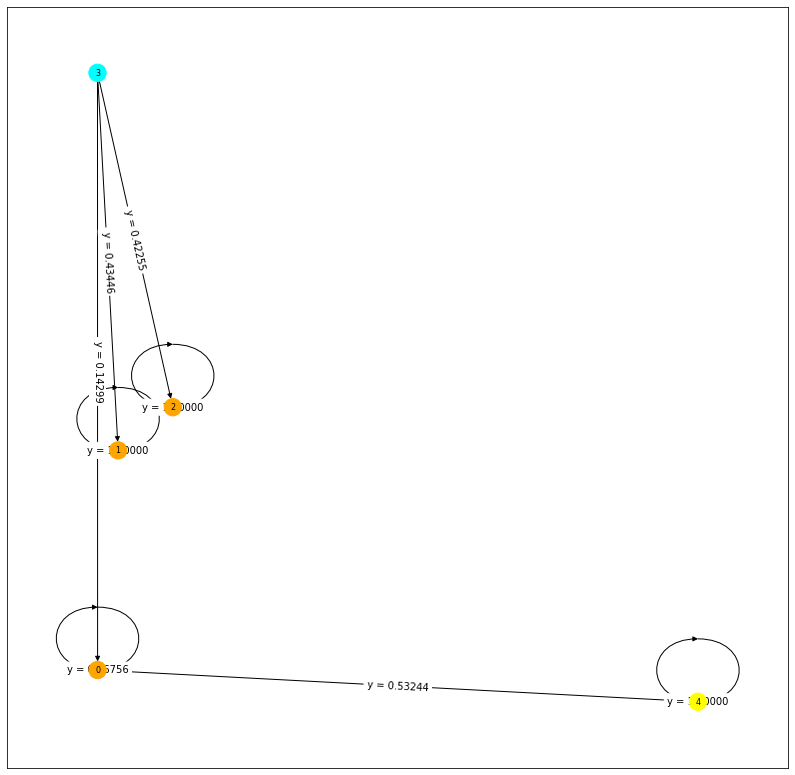

----------------------------------------------------------------------------------------------------
[Iteration: 0]
Pair: (0, 0)
Relaxed y[0][0] + x[0] = 2
[Computing: 0.001 s Optimization: 0.005 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 1]
Pair: (1, 3)
Relaxed y[1][3] + x[1] = 2
[Computing: 0.003 s Optimization: 0.001 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 2]
[Computing: 0.000 s Optimization: 0.000 s]
----------------------------------------------------------------------------------------------------
Finish Cutting Plane algorithm after 0.493 m
Instance 1
Status: OptimizationStatus.OPTIMAL
Obj Value = 1283844.34478, Expected Result = 1324

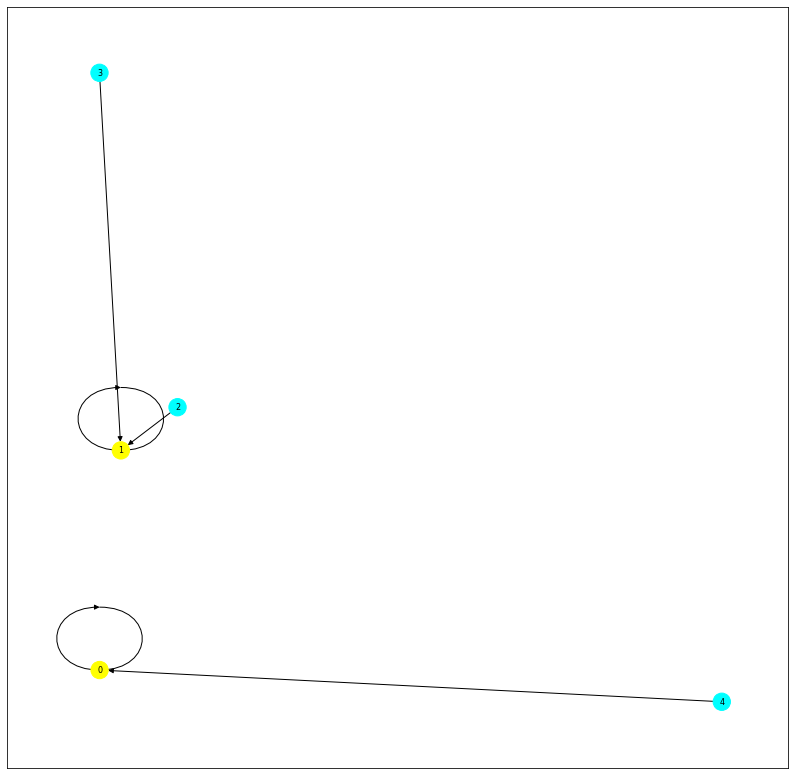

Status: OptimizationStatus.OPTIMAL
Obj Value = 385731.63570, Expected Result = 385611.91779 Gap = 0.03105 %


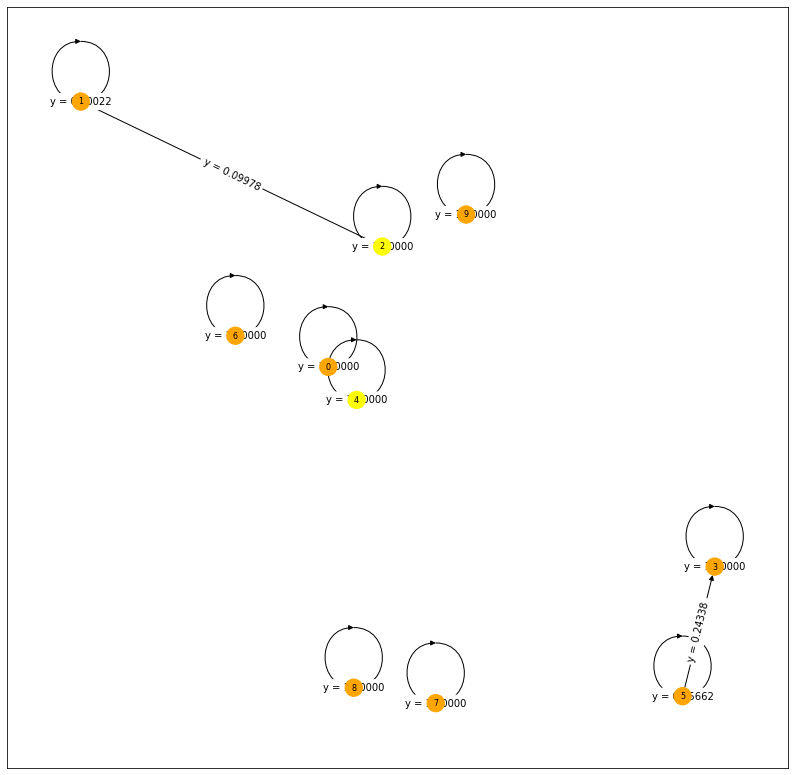

----------------------------------------------------------------------------------------------------
[Iteration: 0]
Pair: (1, 1)
Relaxed y[1][1] + x[1] = 2
[Computing: 0.001 s Optimization: 0.001 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 1]
Pair: (5, 5)
Relaxed y[5][5] + x[5] = 2
[Computing: 0.001 s Optimization: 0.001 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 2]
Pair: (7, 7)
Relaxed y[7][7] + x[7] = 2
[Computing: 0.001 s Optimization: 0.014 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

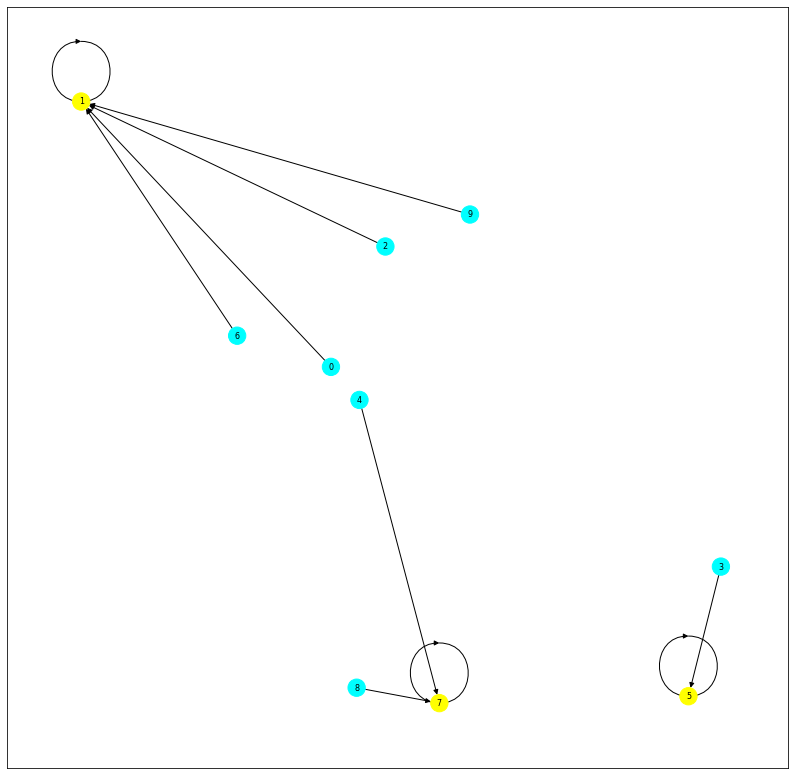

Status: OptimizationStatus.OPTIMAL
Obj Value = 2358204.99290, Expected Result = 2357066.94292 Gap = 0.04828 %


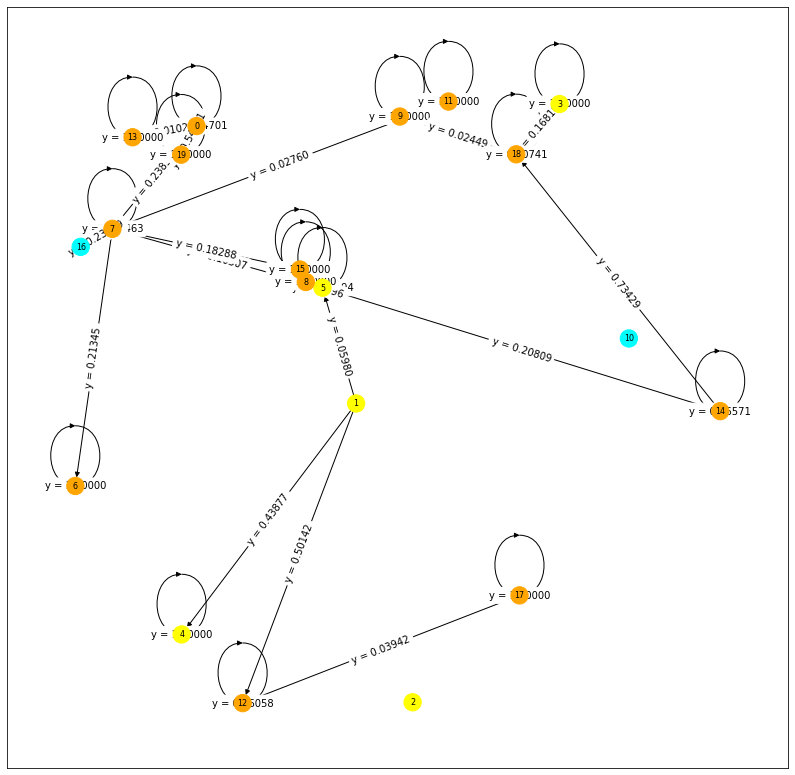

----------------------------------------------------------------------------------------------------
[Iteration: 0]
Pair: (7, 16)
Relaxed y[7][16] + x[7] = 2
[Computing: 0.002 s Optimization: 0.004 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 1]
Pair: (5, 1)
Relaxed y[5][1] + x[5] = 2
[Computing: 0.003 s Optimization: 0.003 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 2]
Pair: (14, 12)
Relaxed y[14][12] + x[14] = 2
[Computing: 0.003 s Optimization: 0.009 s]
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------

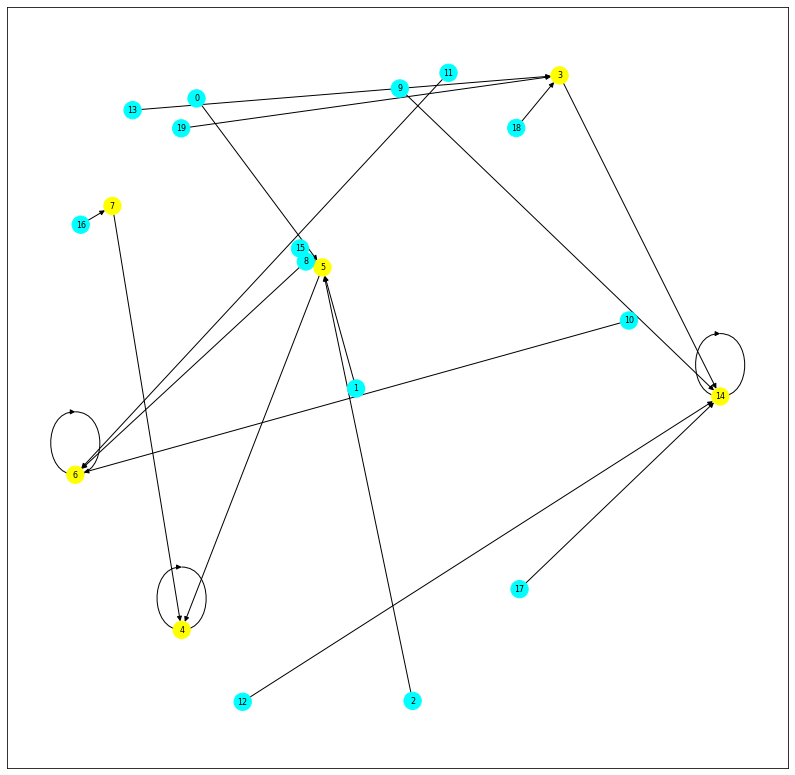

Status: OptimizationStatus.OPTIMAL
Obj Value = 9414876.60375, Expected Result = 9414476.54992 Gap = 0.00425 %


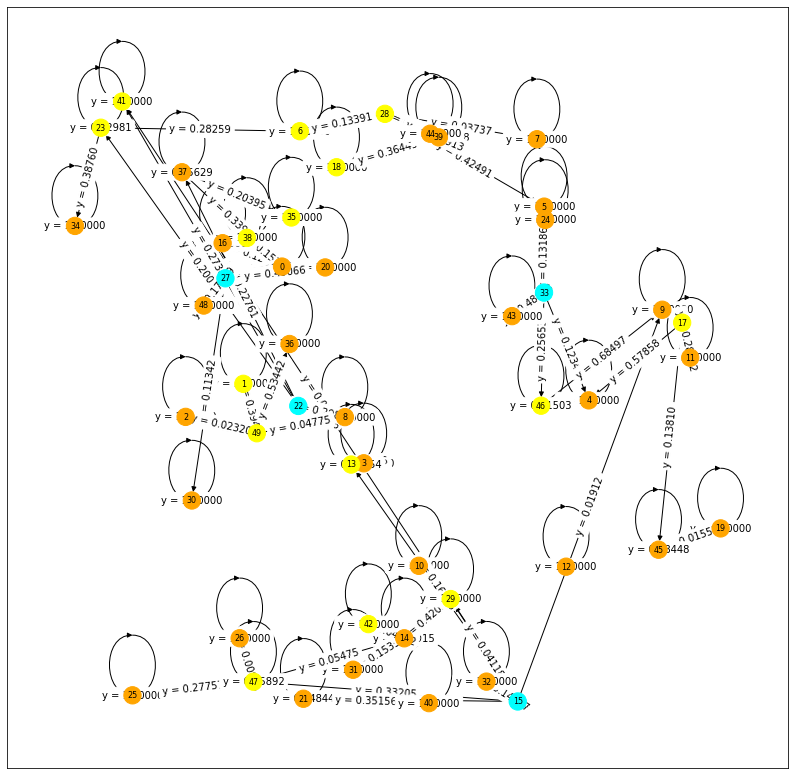

----------------------------------------------------------------------------------------------------
[Iteration: 0]
Pair: (13, 15)
Relaxed y[13][15] + x[13] = 2
[Computing: 0.010 s Optimization: 0.021 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 1]
Pair: (46, 33)
Relaxed y[46][33] + x[46] = 2
[Computing: 0.017 s Optimization: 0.014 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 2]
Pair: (29, 14)
Relaxed y[29][14] + x[29] = 2
[Computing: 0.009 s Optimization: 0.007 s]
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

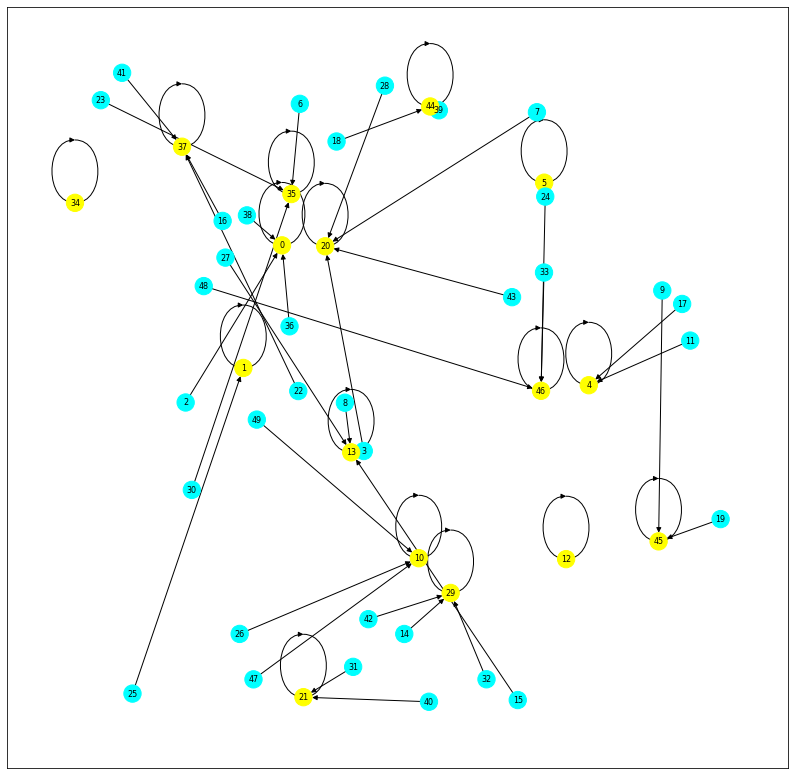

Status: OptimizationStatus.OPTIMAL
Obj Value = 5803531.93545, Expected Result = 5803531.93545 Gap ~ 0.00000 %


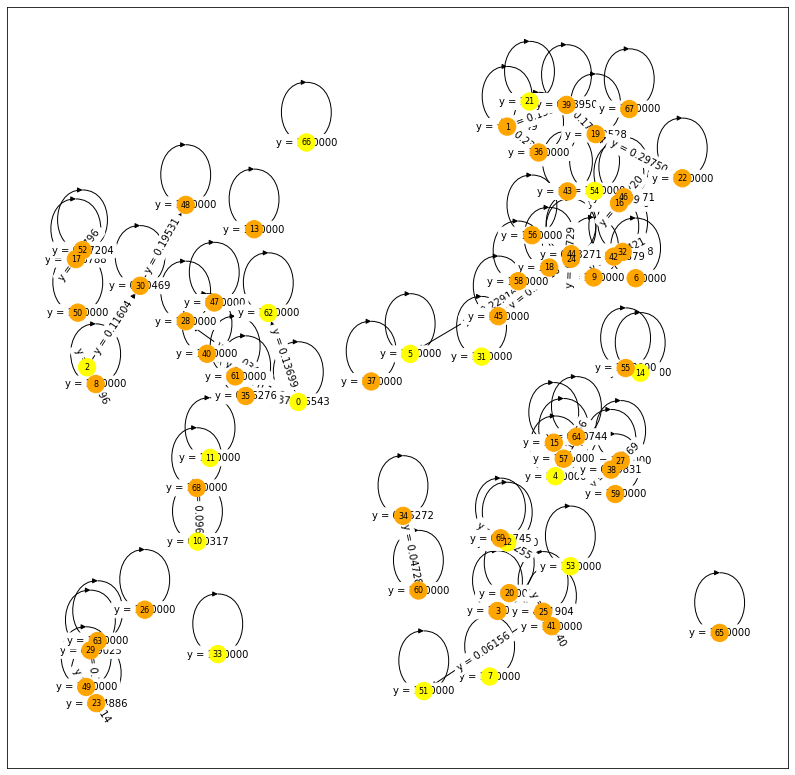

----------------------------------------------------------------------------------------------------
[Iteration: 0]
Pair: (25, 25)
Relaxed y[25][25] + x[25] = 2
[Computing: 0.028 s Optimization: 0.020 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 1]
Pair: (0, 0)
Relaxed y[0][0] + x[0] = 2
[Computing: 0.018 s Optimization: 0.012 s]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[Iteration: 2]
Pair: (1, 39)
Relaxed y[1][39] + x[1] = 2
[Computing: 0.017 s Optimization: 0.022 s]
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------

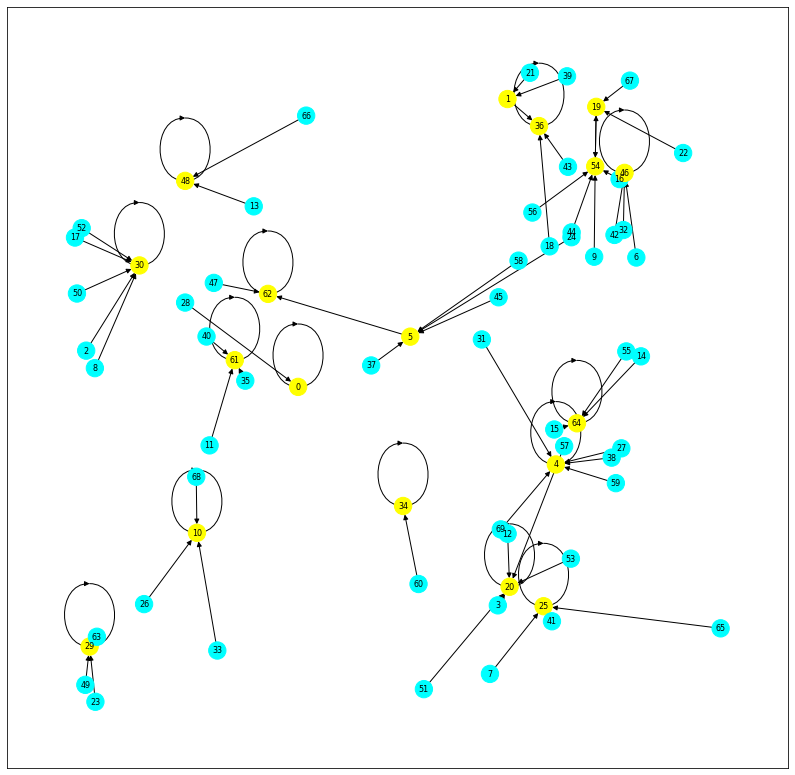

In [43]:
l = 1
u = 10
ids = [i for i in range(l, u + 1)]
executeMultipleInstances(ids)